# CS530 HW8

#### Question 1. (4 points)

a. For classification trees, implement three functions to calculate the (1) cross-entropy, (2) Gini index, and (3) misclassification error. Assume binary classification (labels are 0’s and 1’s). The functions takes p_1, the probability of a record belong to class k=1, as input.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree


def calculate_cross_entropy(p):
    cross_entropy = 0
    for i in p:
        cross_entropy += i * np.log2(i)
    return cross_entropy * -1


def calculate_gini_index(p):
    gini_index = 0
    for i in p:
        gini_index += i * (1 - i)
    return gini_index


def calculate_misclassification_error(p):
    mc_error = 0
    for i in p:
        mc_error += i * (1 - i)
    return mc_error


def split_data_at_value(data, value):
    classification = np.array([])
    for v in data:
        if v >= value:
            classification = np.append(classification, [1])
        else:
            classification = np.append(classification, [0])
    return classification


def calculate_probability_1(data):
    total = len(data)
    ones = np.count_nonzero(data == 1)
    return ones / total

b. Apply the three functions you implemented in 1a on the training test (train.csv) of the heart-disease dataset. Choose the 'age' variable as the root node. Use each value in the 'age' variable as the splitting value. Plot the cross entropy, Gini index, and misclassification error over age on the two child nodes after splitting.

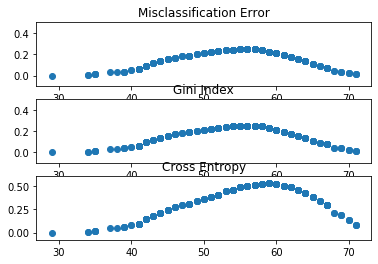

In [2]:
# Your code goes here

trainData = pd.read_csv('data\\train.csv', sep=',', index_col=0)
testData = pd.read_csv('data\\test.csv', sep=',', index_col=0)

giniIndex = np.array([])
crossEntropy = np.array([])
misclassification = np.array([])

for i in trainData['age']:
    split = split_data_at_value(trainData['age'], i)
    probabilities = np.array([calculate_probability_1(split)])
    cross = calculate_cross_entropy(probabilities)
    crossEntropy = np.append(crossEntropy, cross)
    gini = calculate_gini_index(probabilities)
    giniIndex = np.append(giniIndex, gini)
    misError = calculate_misclassification_error(probabilities)
    misclassification = np.append(misclassification, misError)
    # print(f'split: {i}'
    #       f'\nprobability 1: {probabilities[0]}'
    #       f'\ncross entropy : {cross}'
    #       f'\ngini index : {gini}'
    #       f'\nmisclassification error : {misError}')


plt.subplot(3, 1, 1)
plt.ylim(top=.5, bottom=-.1)
plt.title('Misclassification Error')
plt.scatter(x=trainData["age"], y=misclassification)
plt.subplot(3, 1, 2)
plt.title('Gini Index')
plt.ylim(top=.5, bottom=-.1)
plt.scatter(x=trainData["age"], y=giniIndex)
plt.subplot(3, 1, 3)
plt.title('Cross Entropy')
plt.scatter(x=trainData["age"], y=crossEntropy)
plt.show()

c. Discuss what you find in 1b. What age would you choose for the splitting value?

# Discussion
For each measure, there's a noticeably increasing trend across all errors and measures as the
split occurs at a later and later point, maxing out around 60 years old for the largest error.
The place place to split seems to be in the low 40s, however, the lack of data at the lower end could mean
that there are unknowns here that age alone cannot describe.

#### Question 2. (3 points)

a. Implement a function to carry out the regression tree algorithm using the greedy approach. This implementation assumes the tree only splits twice. The function takes inputs X_train, y_train, and X_test, and return a prediction y_pred for X_test.

In [7]:
def regression_tree(X_train, y_train, X_test):
    clf = tree.DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=2).fit(X_train, y_train)
    score = clf.score(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(score)
    return y_pred

b. Use the function you implemented in 2a to predict on the synthetic data below.

In [14]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
# make a linearly separable dataset
X, y = make_regression(n_samples=1000,
                       n_features=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [15]:
# Your code goes here
output = regression_tree(X_train, y_train, X_test)


0.602009862160638


c. Do you think this implementation of the regression tree is a good model for this dataset? Explain.

# Discussion

It's hard to tell if it would be a good fit or not, as there are only 3 features, a regression tree might make sense as 
it has the ability to be truly greedy and brute force all of the allowed splits at max depth without using up 
a huge amount of time and processing power. Because of that, a decision tree seems to be an okay choice, but its accuracy
is not consistent with the random nature of the dataset provided. Beacuse of that, there may be other ideal classifiers for this 
dataset.

#### Question 3. (3 points)

a. Use the scikit-learn package to run Bagging and Random Forest on the heart-disease dataset and predict on its test set. Use cross-validation to find the best parameters for these algorithms.

In [8]:
# Your code goes here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def fit_bag_est(desc, target, estimators=10):
    bag = BaggingClassifier(n_estimators=estimators, oob_score=True)
    bag.fit(desc, target)
    score = bag.oob_score_
    print(score)
    return bag


def fit_forest_est(desc, target, estimators=10):
    forrest = RandomForestClassifier(n_estimators=estimators, oob_score=True)
    forrest.fit(desc, target)
    score = forrest.oob_score_
    print(score)
    return forrest


def calc_roc(trainTarget, testTarget, predictor):
    confusion_matrix = pd.crosstab(testTarget, predictor)
    metrics.accuracy_score(testTarget, predictor)
    predict_probabilities = predictor.predict_proba(trainTarget)
    fpr, tpr, thr = metrics.roc_curve(testTarget, predict_probabilities[:, 1])
    return fpr, tpr, thr


trainData = pd.read_csv('data\\train.csv', sep=',', index_col=0)
testData = pd.read_csv('data\\test.csv', sep=',', index_col=0)

trainDescriptors = trainData.drop(columns=['target'], axis=1)
trainTarget = trainData['target']

testDescriptors = testData.drop(columns=['target'], axis=1)
testTarget = testData['target']

bagEst = fit_bag_est(trainDescriptors, trainTarget, 100)
bagPredictor = bagEst.predict(testDescriptors)
print(bagPredictor)

forrestEst = fit_bag_est(trainDescriptors, trainTarget, 100)
forrestPredictor = forrestEst.predict(testDescriptors)
print(forrestPredictor)


descriptors = len(trainDescriptors.columns)
maxSplit = 20

minEstimators = 1
maxEstimators = descriptors * maxSplit

bagError = np.array([])
forrestError = np.array([])

for i in range(minEstimators, maxEstimators):
    bagEst = fit_bag_est(trainDescriptors, trainTarget, i)
    bagPredictor = bagEst.predict(testDescriptors)
    bagError = np.append(bagError, bagEst.oob_score_)

    forrestEst = fit_bag_est(trainDescriptors, trainTarget, i)
    forrestPredictor = forrestEst.predict(testDescriptors)
    forrestError = np.append(forrestError, forrestEst.oob_score_)

x = range(minEstimators, maxEstimators)
plt.plot(x, bagError)
plt.show()

x = range(minEstimators, maxEstimators)
plt.plot(x, forrestError)
plt.show()


b. On the same axes, plot the ROC curves for the two algorithms with the best parameters that you found in 3a. Annotate their AUC values and compare their performance. 

c. Explain your results in 3b. Why might the results vary across algorithms?

In [10]:
# Your discussion goes here